### *This file allows to initialize a DA spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx, DelimitedFiles
using Interpolations, NmodController
include("DA_kinetics.jl") # Loading of DA kinetics of gating variables
include("DA_ODE.jl") # Loading of DA model
include("STG_utils.jl") # Loading of some utils functions
include("DA_large_simulations.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 300000
const tspan  = (0.0, Tfinal)

# Definition of the number of cells in the random set
const ncells = 200

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1)
default(fmt = :png)

# Moving average function
moving_average(vs, n, padding) = [sum(vs[i:(i+n-1)])/n for i in 1:padding:(length(vs)-(n-1))];

# **Building the model**

In [3]:
### DA model
# Building Na current
DA_NaCurrent = initializeCurrent("Na", DA_VNa, numberOfGatings=2, exponents=[3, 1],
    activationSteadyStateGating=DA_mNa_inf, activationTimeConstant=DA_tau_mNa,
    inactivationSteadyStateGating=DA_hNa_inf, inactivationTimeConstant=DA_tau_hNa)

# Building Kd current
DA_KdCurrent = initializeCurrent("Kd", DA_VK, exponents=3,
    activationSteadyStateGating=DA_mKd_inf, activationTimeConstant=DA_tau_mKd)

# Building CaL current
DA_CaLCurrent = initializeCurrent("CaL", DA_VCa, exponents=2,
    activationSteadyStateGating=DA_mCaL_inf, activationTimeConstant=DA_tau_mCaL)

# Building CaN current
DA_CaNCurrent = initializeCurrent("CaN", DA_VCa, exponents=1,
    activationSteadyStateGating=DA_mCaN_inf, activationTimeConstant=DA_tau_mCaN)

# Building ERG current
DA_ERGCurrent = initializeCurrent("ERG", DA_VK, exponents=1,
    activationSteadyStateGating=DA_o_inf, activationTimeConstant=DA_tau_o)

# Building NMDA current
DA_NMDACurrent = initializeCurrent("NMDA", DA_VNMDA, exponents=1,
    activationSteadyStateGating=DA_NMDA_inf, activationTimeConstant=DA_tau_NMDA,
    MgDependency=true)

# Building a more complex model with calcium
DA_ionCurrents = [DA_NaCurrent, DA_KdCurrent, DA_CaLCurrent, DA_CaNCurrent, DA_ERGCurrent, DA_NMDACurrent]
DA_gvec_spiking = [30., 5., 0.03, 0.03, 0.12, 0.]
DA_spiking = initializeNeuronModel(DA_ionCurrents, C=1., leakageConductance=0.01, reversaleLeakagePotential=DA_Vleak,
    maximumConductances=DA_gvec_spiking);

In [4]:
#writeControlledODEs(DA_spiking, ["CaL", "CaN"], ["s", "u"], filename="DA_ODE.jl")

# **Neuromodulation gCaL and gCaN overall**

## **Computation of gCaL and gCaN**

In [4]:
# Defining some timescales
DA_tauFast = DA_tau_mNa
DA_tauSlow = DA_tau_mKd
DA_tauUltraslow(V) = 100.
DA_gf_spiking, DA_gs_spiking, DA_gu_spiking = computeDICs(DA_spiking, DA_tauFast, DA_tauSlow, DA_tauUltraslow, Mg=1.4)
DA_S_spiking = computeDICs(DA_spiking, DA_tauFast, 
    DA_tauSlow, DA_tauUltraslow, onlyS=true, Mg=1.4)
DA_Vth = computeThresholdVoltage(DA_gf_spiking, DA_gs_spiking, DA_gu_spiking)

-62.89674965143292

In [5]:
DA_Vth = -55.5 # Here, the algorithm is not able to find any threshold voltage

-55.5

In [6]:
Random.seed!(544)
SVth_unnorm = zeros(3, 6)
g_all_spiking = zeros(ncells, 7)
gsth = 0.5
guth = 5.
gfth = -3.89388 * gsth - 11.05758

# Retrieving which line of the sensitivity matrix matter
timescales = [1, 2, 3]

# Retrieving which column of the sensitivity matrix belong to unmodulated conductances
unmodulated = [2, 3, 6]

# Retrieving which column of the sensitivity matrix belong to modulated conductances
modulated = [1, 4, 5]

for i = 1 : ncells
    gleak = 0.008667 + 0.008667 * rand(1, 1)[1]
    gCaL = gleak * (0.015 + 0.06 * rand(1, 1)[1]) / 0.013
    gKd = gleak * (6. + 4. * rand(1, 1)[1]) / 0.013
    gNMDA = gleak * (0.12) / 0.013
    
    DA_i = initializeNeuronModel(DA_ionCurrents, C=1., leakageConductance=gleak, 
        reversaleLeakagePotential=DA_Vleak, maximumConductances=ones(6))
    
    S_i = computeDICs(DA_i, DA_tauFast, DA_tauSlow, DA_tauUltraslow, onlyS=true, scaled=false, Mg=1.4)
    SVth = S_i(DA_Vth)
    
    SVth_unnorm = deepcopy(SVth)
    
    SVth = SVth ./ gleak
    
    gDICr = [gfth, gsth, guth]
    gDICr = gDICr - SVth[timescales, unmodulated] * collect([gKd, gCaL, gNMDA])

    # Computing the left hand side of the linear system
    Smod = SVth[timescales, modulated]

    # Computing the solution of the linear system
    g_r = \(Smod, gDICr)
    g_all_spiking[i, :] = [g_r[1], gKd, gCaL, g_r[2], g_r[3], gNMDA, gleak]
end

In [7]:
# Definition of parameters
C = 1
Mg = 1.4
α = 5e-3 # Rate of transfer between intracellular and membrane
β = 5e-3 # Rate of degradation of intracellular proteins
Kp = 3e-4 # Proprtional gain
Ki = 5e-6 # Integral gain
DA_gsth_t(t) = 0.5 - 4.5 * (t > Tfinal/2) # Reference gs(Vth)
DA_guth_t(t) = 5. # Reference gu(Vth)

# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
tau_Na = 600 # Sodium integral action time constants
Ca_tgt(t) = 3. # Calcium target

# Input current definition
Iapp(t) = 0.

tt = 0. : 0.2 : Tfinal

window_size_s = 5
padding_s = 0.2
window_size_ = Int64(round(window_size_s*1000*length(tt)/(Tfinal)))
padding_ = Int64(round(padding_s*1000*length(tt)/(Tfinal)))
tt_moving_average_ = window_size_s/2 : padding_s : Tfinal/1000 - window_size_s/2
tt_moving_average_plot = range(0, Tfinal/1e3, length(tt_moving_average_));

In [9]:
# gNa_matrix, gKd_matrix, gCaL_matrix, gCaN_matrix, gERG_matrix, gNMDA_matrix, 
# gleak_matrix, Ca_ma_matrix = simulate_DA_population(g_all_spiking, Iapp, tau_Na, tau_g, Ca_tgt,
#                                                      C, Mg, α, β, Kp, Ki, SVth_unnorm,
#                                                      DA_gsth_t, DA_guth_t, tt)

Computing... 100%|███████████████████████████████████████| Time: 1:22:04


([25.057022929029948 29.122658653034883 … 61.692654487774114 62.06224336794903; 24.81270353997331 28.776693767148245 … 54.48070045710286 54.752423113910915; … ; 34.81264679932734 38.66952433753898 … 56.62415539338678 56.33035402671488; 22.791731487901266 26.785443091398033 … 52.17108830277987 51.97449074826079], [5.646133544845411 6.562248851416981 … 13.901290945877246 13.984570918123511; 8.269419418365487 9.590512773062697 … 18.156980014705127 18.247538006948876; … ; 10.750058638862683 11.941052818000017 … 17.48539817624126 17.394673045856212; 7.726693955257979 9.080614227711463 … 17.68667873446587 17.62002960177672], [0.025467073583607062 0.02611589207508925 … 0.03674786238341168 0.03674128903438537; 0.048831191688330194 0.05003993993660545 … 0.08551127695420309 0.08548680326883713; … ; 0.07911963347775604 0.08044671883972096 … 0.10307032784063899 0.10309364049866306; 0.03003734794723824 0.030858134883604983 … 0.046781602968694824 0.04678819735289225], [0.030286119063570118 0.0310577

In [10]:
# writedlm("./data_DA/gNa_matrix.dat", gNa_matrix)
# writedlm("./data_DA/gKd_matrix.dat", gKd_matrix)
# writedlm("./data_DA/gCaL_matrix.dat", gCaL_matrix)
# writedlm("./data_DA/gCaN_matrix.dat", gCaN_matrix)
# writedlm("./data_DA/gERG_matrix.dat", gERG_matrix)
# writedlm("./data_DA/gNMDA_matrix.dat", gNMDA_matrix)
# writedlm("./data_DA/gleak_matrix.dat", gleak_matrix)
# writedlm("./data_DA/Ca_ma_matrix.dat", Ca_ma_matrix)

In [8]:
gNa_matrix = readdlm("./data_DA/gNa_matrix.dat")
gKd_matrix = readdlm("./data_DA/gKd_matrix.dat")
gCaL_matrix = readdlm("./data_DA/gCaL_matrix.dat")
gCaN_matrix = readdlm("./data_DA/gCaN_matrix.dat")
gERG_matrix = readdlm("./data_DA/gERG_matrix.dat")
gNMDA_matrix = readdlm("./data_DA/gNMDA_matrix.dat")
gleak_matrix = readdlm("./data_DA/gleak_matrix.dat")
Ca_ma_matrix = readdlm("./data_DA/Ca_ma_matrix.dat");

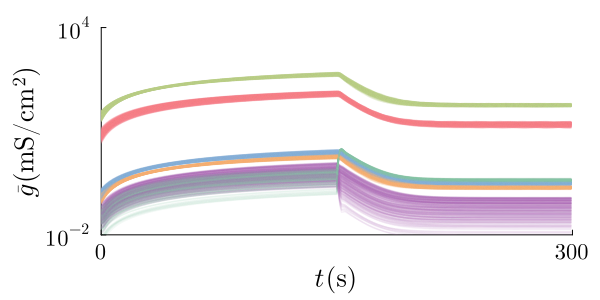

In [17]:
p1 = plot(ylims=(1e-2, 1e4), yticks=([1e-2, 1e4], [L"10^{-2}", L"10^{4}"]), guidefontsize=18,
           xticks=([0, 300], [L"0", L"300"]), tickfontsize=15, size=(600, 300), xlims=(0, 300))

xlabel!(L"t\,\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")

for i = 1 : ncells
    plot!(tt[2:5000:end]./1e3, gNa_matrix[i, :], color=myApple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKd_matrix[i, :], color=myPink, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaL_matrix[i, :], color=myPurple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaN_matrix[i, :], color=myGreen, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gERG_matrix[i, :], color=myBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gNMDA_matrix[i, :], color=myOrange, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
#     plot!(tt[2:5000:end]./1e3, gleak_matrix[i, :], color=myDarkBlue, linewidth=1.5,
#           legend=false, alpha=0.1, yaxis=:log)
end

display(p1)
# savefig(p1, "./figures/g_all_DA.pdf")

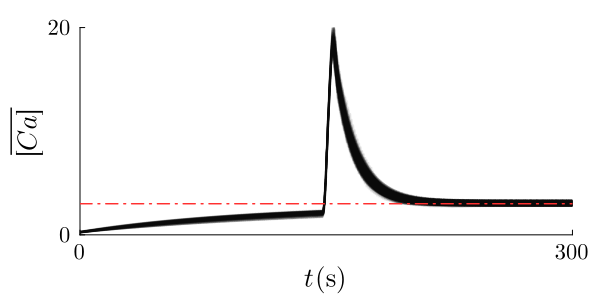

In [17]:
p1b = plot(size=(600, 300), ylims=(0, 20), yticks=([0, 20], [L"0", L"20"]), 
           xlims=(0, 300), guidefontsize=18, xticks=([0, 300], [L"0", L"300"]), tickfontsize=15)

ylabel!(L"\overline{[Ca]}")
xlabel!(L"t\,\mathrm{(s)}")

for i = 1 : ncells
    plot!(tt_moving_average_plot, Ca_ma_matrix[i, :], linewidth=1.5, color=:black, 
          alpha=0.05, legend=false)
end

plot!([0, 300], [3, 3], color=:firebrick1, linestyle=:dashdot, linewidth=1.5)

display(p1b)
# savefig(p1b, "./figures/Ca_ma_DA.pdf")